## **Modeling**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# 타겟 변수와 입력 변수 정의
y = df['Thick']
X = df[['PT_jo_V_1', 'PT_jo_A_Main_1', 'PT_jo_TP']]

# 학습용/테스트용 데이터 분리 (랜덤 시드 고정)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

## 하이퍼파라미터 설정 (GridSearchCV)

Optuna도 사용해 봤지만 GridSearchCV에 비해 성능이 안좋았음

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# 하이퍼파라미터 후보 설정
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt']
}

# 모델 정의
rf = RandomForestRegressor(random_state=42)

# GridSearchCV로 탐색
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           cv=3, n_jobs=-1, scoring='neg_mean_squared_error', verbose=1)

# 학습
grid_search.fit(X_train, y_train)

# 결과
best_model = grid_search.best_estimator_
print("최적 하이퍼파라미터:", grid_search.best_params_)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
최적 하이퍼파라미터: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


## 모델링

GridSearchCV를 활용한 최적 하이퍼 파라미터 탐색 뒤 모델링

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# 최적 하이퍼파라미터로 모델 정의
# 최적 모델 RandomForestRegressor
best_model = RandomForestRegressor(
    n_estimators=300,
    max_depth=20,
    max_features='sqrt',
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42
)

# 학습
best_model.fit(X_train, y_train)

# 예측
y_pred = best_model.predict(X_test)

def regression_accuracy(y_true, y_pred, tolerance):
    # 실제값 기준 10% 오차 범위 계산
    lower_bound = y_true * (1 - tolerance)
    upper_bound = y_true * (1 + tolerance)

    # 범위 내에 있는 예측값 비율 계산
    accurate = np.logical_and(y_pred >= lower_bound, y_pred <= upper_bound)
    accuracy = np.mean(accurate)

    return accuracy

# 사용 예
acc = regression_accuracy(y_test, y_pred, tolerance=0.1)
print(f"🎯 10% tolerance accuracy: {acc * 100:.2f}%")

# 성능 평가
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("✅ 최적 모델 성능")
print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

🎯 10% tolerance accuracy: 89.63%
✅ 최적 모델 성능
RMSE: 1.4885
R² Score: 0.6458


## 시각화

- 예측값 - 실제값 산점도

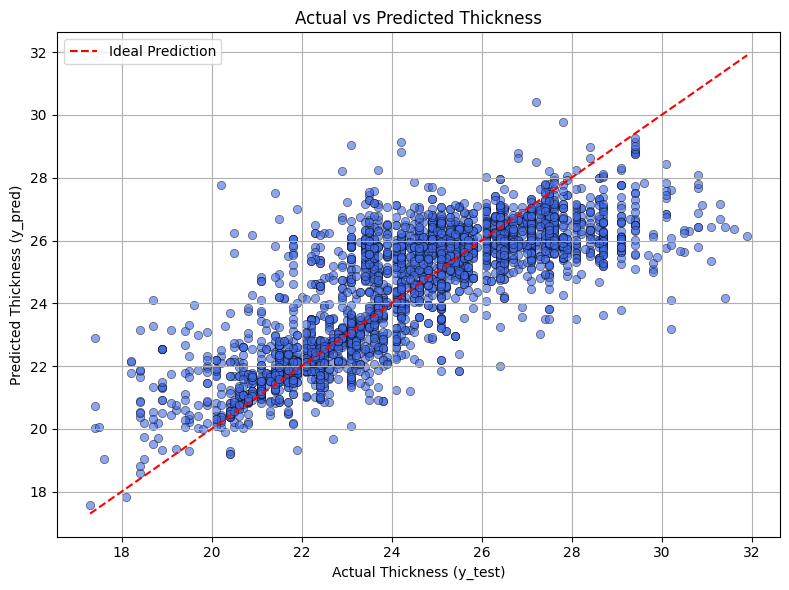

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 예측값
y_pred = best_model.predict(X_test)

# 시각화
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, color='royalblue', alpha=0.6, edgecolor='k')

# 기준선 (완벽한 예측일 때의 직선)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Ideal Prediction')

plt.xlabel("Actual Thickness (y_test)")
plt.ylabel("Predicted Thickness (y_pred)")
plt.title("Actual vs Predicted Thickness")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

- 잔차(residuals) 분석

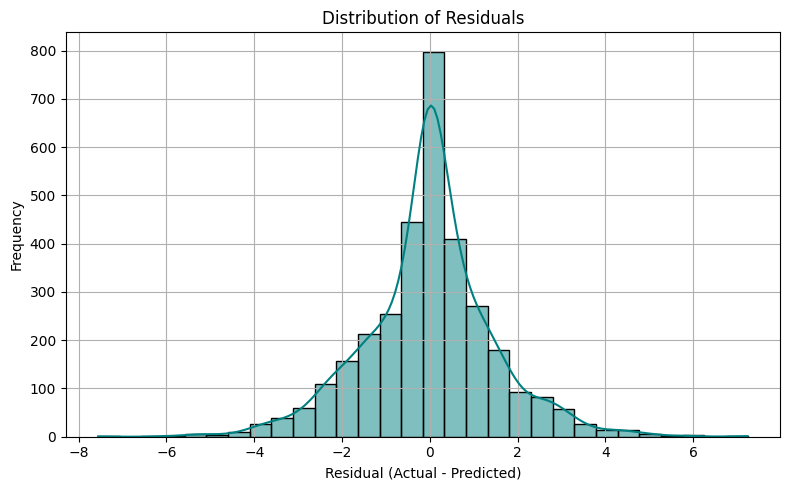

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 예측값
y_pred = best_model.predict(X_test)

# 잔차 계산
residuals = y_test - y_pred

# 잔차 분포 확인 (히스토그램 + 커널 밀도)
plt.figure(figsize=(8, 5))
sns.histplot(residuals, kde=True, color='teal', bins=30)
plt.title("Distribution of Residuals")
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()